In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Linear Regression

Linear regression is foundational to deep learning. We must understand this.

## Make Fake Data

699.0743941233562

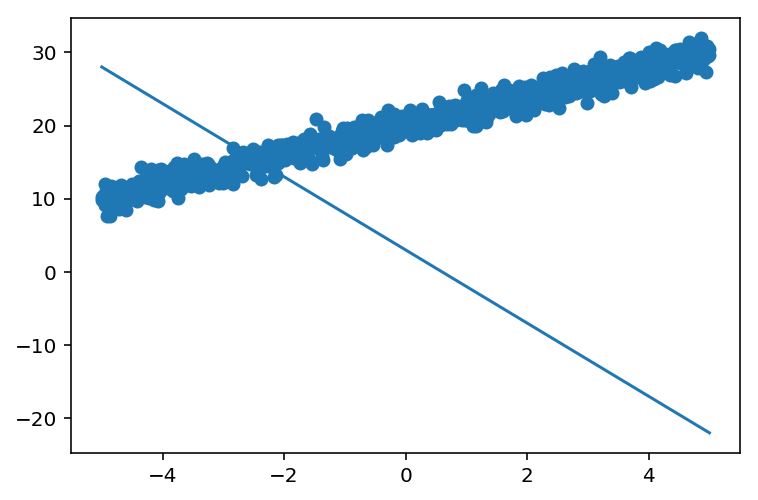

In [2]:
x = np.linspace(-5, 5, 1000)
w_true = 2
b_true = 20

def noise(n):
    return np.random.normal(size=(n))

y = w_true * x + b_true + noise(len(x))
# Plot actual data
plt.scatter(x, y)

# Plot a very bad estimate
w = -5
b = 3
y_est = w * x + b
plt.plot(x, y_est)

# Define a mean squared error "loss function"
# Loss function measures how wrong our model is

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

mse(y, y_est)

# Interactive Activity: Let's optimize the model.

In [6]:
@interact(
    w=FloatSlider(min=-10, max=10, step=0.1), 
    b=FloatSlider(min=10, max=30, step=0.1)
)
def optimize_plot(w, b):
    y_est = x * w + b
    plt.scatter(x, y, alpha=0.3)
    plt.plot(x, y_est, color='red')
    plt.title(mse(y, y_est))

interactive(children=(FloatSlider(value=0.0, description='w', max=10.0, min=-10.0), FloatSlider(value=10.0, de…

In [9]:
# Define a form for the model
def model(p, x):
    """
    :param p: parameters
    :param x: data
    """
    # Keep this: it makes it clear the mapping between w, b, and p.
    w = p[0]
    b = p[1]
    return w * x + b  # take out in student version.

# Initialize p using random numbers.
# Be sure to mention this. 
p = np.random.normal(size=(2,))

# Differentiable loss function w.r.t. 1st argument
def loss(p, x, y):
    """
    :param p: parameters to optimize
    :param x: input data
    :param y: correct outputs
    """
    y_est = model(p, x)
    return mse(y, y_est)   # take out in student version.

from autograd import elementwise_grad as egrad

dloss = egrad(loss)  # derivative of loss.

# Optimization routine
losses = []
for i in range(2000):
    p = p - dloss(p, x, y) * 0.001
    losses.append(loss(p, x, y))

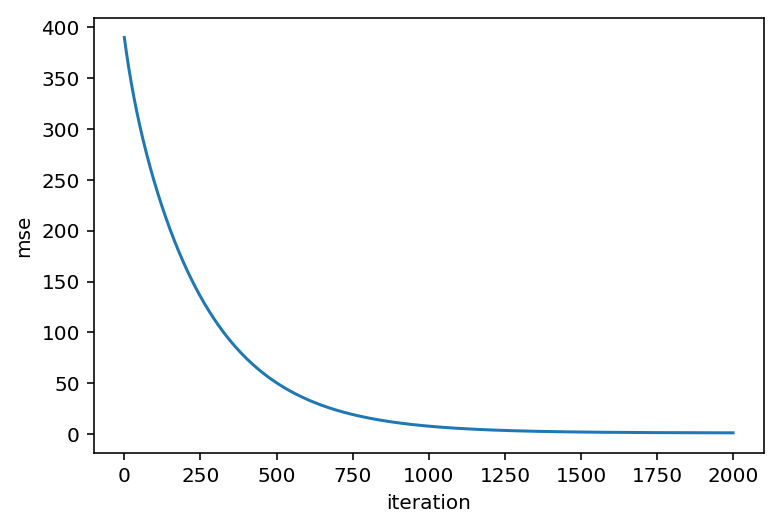

In [12]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

# Ingredients of any mathematical model to be optimized

1. Model specification ("equations") ($y = wx + b$)
2. Parameters of the model to be optimized ($w$ and $b$, or more generally, $p$)
3. Loss function: tells us how wrong our model parameters are w.r.t. the data ($MSE$)
4. Opitmization routine (for-loop)

# Logistic Regression

In [17]:
def logistic(x):
    return 1 / (1 + np.exp(-x))


@interact(
    w=FloatSlider(min=-5, max=5, step=0.1), 
    b=FloatSlider(min=-5, max=5, step=0.1)
)
def plot_logistic(w, b):
    x = np.linspace(-10, 10, 1000)
    z = w * x + b  # linear transform on x
    y = logistic(z)
    plt.plot(x, y)

interactive(children=(FloatSlider(value=0.0, description='w', max=5.0, min=-5.0), FloatSlider(value=0.0, descr…

## Make fake data

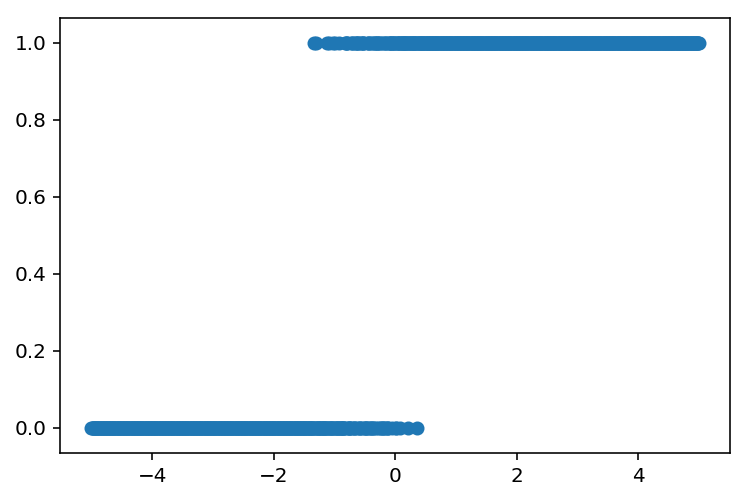

In [51]:
x = np.linspace(-5, 5, 1000)
w = 2
b = 1
z = w * x + b + np.random.normal(size=(len(x))) # Make some noisy data
y_true = np.round(logistic(z))
plt.scatter(x, y_true)

NOTE TO SELF: Define logistic loss function up-front. Explain the two components: loss for class 0 and loss for class 1. Work out on paper four scenarios: two good predictions (one per class), and two bad predictions (one per class).

Give a teaser to the class: "logistic" is an "activation" function! --> borrowed term from what computer scientists thought were how neurons were "activated".

In [58]:
def model(p, x):
    """
    Logistic regression model
    """
    w = p[0]
    b = p[1]
    z = w * x + b
    y = logistic(z)
    return y

def loss(p, x, y):
    preds = model(p, x)
    return -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))

dloss = egrad(loss)

p = np.random.uniform(1, 5, size=(2,))

losses = []
for i in range(2000):
    p = p - dloss(p, x, y_true) * 0.01
    losses.append(loss(p, x, y_true))

In [59]:
p

array([2.80270951, 1.52447069])

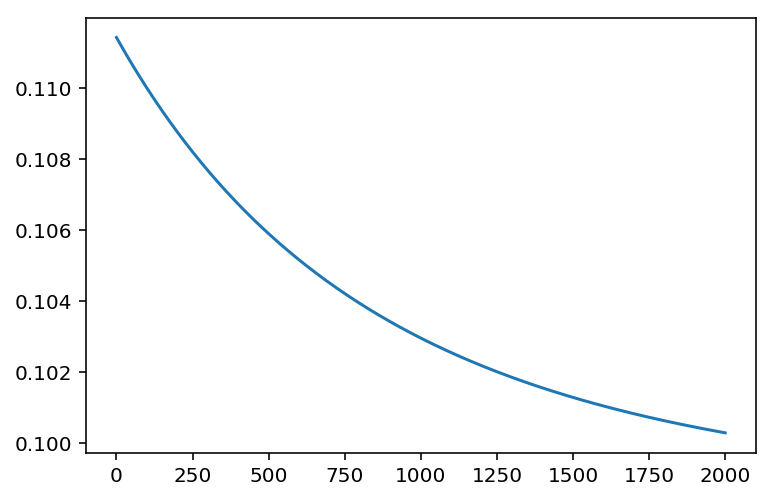

In [60]:
plt.plot(losses)

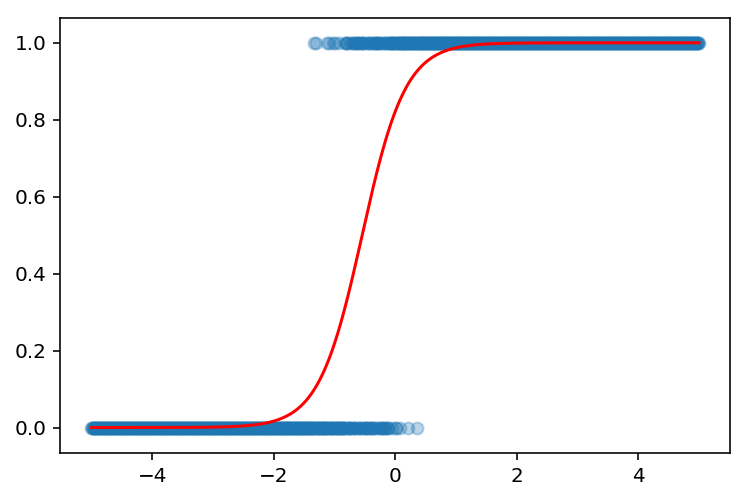

In [64]:
plt.scatter(x, y_true, alpha=0.3)
plt.plot(x, model(p, x), color='red')

# Neural Networks

Very powerful, arbitrary math equations that also take our data and map it to some output, but does so without ever knowing what the true equation form is.

That's all a neural network model is.

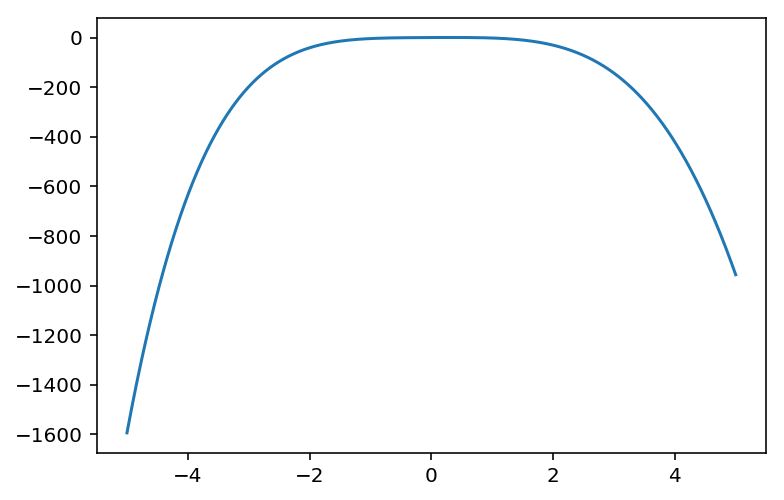

In [103]:
def true_function(x, noise=False):
    y = 0.1 * np.power(x, 5) - 2 * np.power(x, 4) + 0.01 * np.power(x, 3) - np.power(x, 2) + x
    if noise:
        y += np.random.normal(scale=1, size=(len(x)))
    return y

x = np.linspace(-5, 5, 1000).reshape(-1, 1)
y_true = true_function(x, noise=False)
plt.plot(x, y_true)

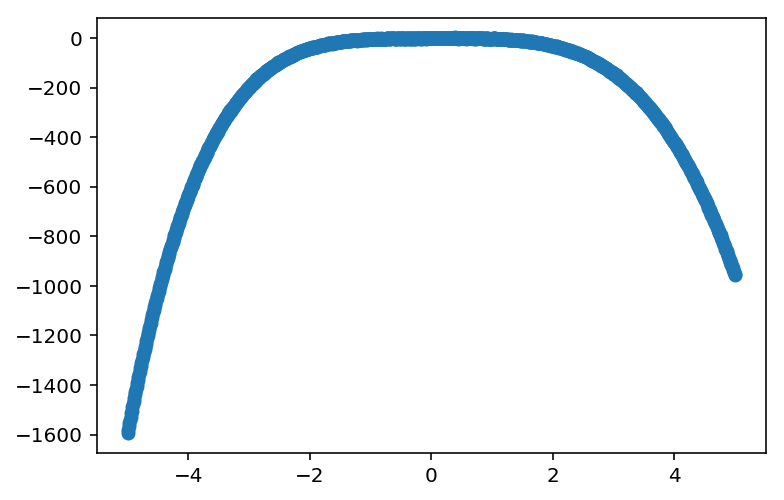

In [104]:
y_measured = true_function(x.squeeze(), noise=True)
plt.scatter(x, y_measured)

In [105]:
from tqdm import tqdm_notebook as tqdmn

In [106]:
# Parameters p
p = dict()
def noise(size):
    return np.random.normal(size=size)

# Initialize parameters
p['w1'] = noise((1, 50))
p['b1'] = noise((50,))

p['w2'] = noise((50, 20))
p['b2'] = noise((20,))

p['w3'] = noise((20, 1))
p['b3'] = noise((1,))

# Terminology to introduce:
# - "layers"
# - "activation function"
# - "deep" vs. "shallow"
# - "loss function" <> "cost function"

def model(p, x, unflattener):
    p = unflattener(p)
    # "a1" is the activation from layer 1
    a1 = np.tanh(np.dot(x, p['w1']) + p['b1'])
    # "a2" is the activation from layer 2
    a2 = np.tanh(np.dot(a1, p['w2']) + p['b2'])
    # "a3" is the activation from layer 3
    a3 = np.dot(a2, p['w3']) + p['b3']
    return a3

def loss(p, x, y, unflattener):
    preds = model(p, x, unflattener)
    return mse(y, preds)

dloss = egrad(loss)

losses = []
from autograd.misc import flatten
# This is autograd-specific
p_flat, unflattener = flatten(p)
for i in tqdmn(range(2000)):
    p_flat = p_flat - dloss(p_flat, x, y_measured, unflattener) * 0.01
    losses.append(loss(p_flat, x, y_measured, unflattener))

/Users/maer3/anaconda/envs/dl-workshop/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:88: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


KeyboardInterrupt: 

In [ ]:
plt.plot(losses)

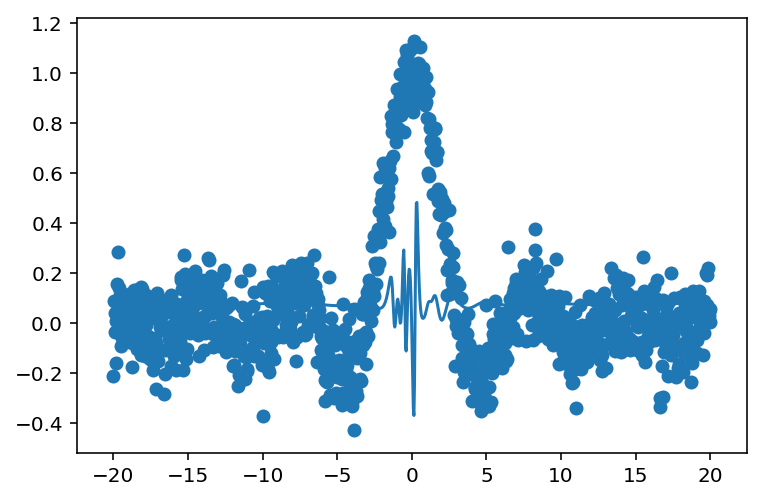

In [99]:
y_pred = model(p_flat, x, unflattener)
plt.plot(x, y_pred)
plt.scatter(x, y_measured)

Applications!

- Given X -> predict Y

Parting notes:

- Practice
- Resources